In [1]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
from qini_curve import qini_df
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")

In [2]:
df["old_target"] = 1

df.loc[df["target_class"].isin([0, 2]), "old_target"] = 0

feature_cols = [
    "recency",
    "history",
    "used_discount",
    "used_bogo",
    "is_referral",
    "zip_code_Rural",
    "zip_code_Surburban",
    "zip_code_Urban",
    "channel_Multichannel",
    "channel_Phone",
    "channel_Web",
]
target_col = "old_target"
treatment_col = "treatment"

In [3]:
df_train, df_test = train_test_split(
    df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25
)
df_train.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target
2052,12,42.76,1,0,1,0,0,1,0,0,1,0,0.477596,0.002233,0.492098,0.028073,0.098630,0,0
9188,3,236.74,1,1,0,0,1,0,0,0,1,0,0.338212,0.149336,0.319221,0.193231,0.141542,1,1
6079,4,46.65,1,0,1,1,0,0,1,0,0,1,0.430861,0.026719,0.436040,0.106380,0.275457,2,0
9711,1,349.65,1,0,0,0,1,0,0,0,0,1,0.421712,0.128117,0.272425,0.177745,0.323655,1,1
11499,9,155.39,0,1,1,0,0,1,0,0,0,1,0.491633,0.014481,0.447632,0.046254,0.130083,0,0


In [4]:
from causalml.inference.meta import BaseXClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

# создадим базовый X-learner
x_learner = BaseXClassifier(
    outcome_learner=LogisticRegression(random_state=13),
    effect_learner=LinearRegression(),
)

# создайте классификатор с логистической регрессией,
# указав outcome_learner=LogisticRegression(random_state=13)
# и линейной регрессией для uplift-классификатора
# указав effect_learner=LinearRegression()

# для обучения нужны датафрейм с факторами и колонка с фактом воздействия
x_learner.fit(
    X=df_train[feature_cols], treatment=df_train[treatment_col], y=df_train[target_col]
)

uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))

# оцените Qini Score для обученного классификатора на тестовой выборке

df_test["uplift_score"] = uplift_vals

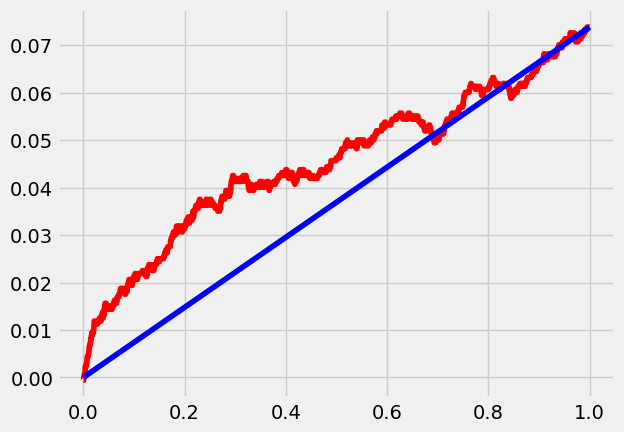

np.float64(26.86415)

In [5]:
qini_df(df_test)